### 모바일 넷 파인 튜닝

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
import math
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

2024-08-04 19:09:31.139438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-04 19:09:31.156533: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-04 19:09:31.161652: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-04 19:09:31.175229: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-04 19:09:32.019521: W tensorflow/compiler/tf2

In [2]:
print(tf.__version__)

### GPU negative 문제 해결
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

### GPU 사용 가능 여부 확인
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("사용 가능한 GPU:")
    for gpu in gpus:
        print(gpu)
else:
    print("GPU가 인식되지 않았습니다.")

2.17.0
사용 가능한 GPU:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


I0000 00:00:1722766173.095275   28912 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722766173.135765   28912 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722766173.137791   28912 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("png2x") # svg, retina, png2x ...
mpl.style.use("seaborn-v0_8")
mpl.rcParams.update({"figure.constrained_layout.use": True})
sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "DejaVu Sans")
plt.rcParams["axes.unicode_minus"] = False

In [4]:
from sklearn.model_selection import train_test_split

### 경로 불러오기
- train, test 를 따로 불러오지 않고 하나의 폴더째로 불러와서 나눈후 테스트 데이터에 대해서만 증강

In [5]:
def load_images_and_labels(files, label, size):
    images = [image.load_img(p, target_size=(size, size)) for p in files]  # warping
    labels = [label] * len(files)
    print(files)
    return images, labels

In [6]:
man_file= glob('../data/imgs/data_mw/man/*jpg')
wom_file= glob('../data/imgs/data_mw/woman/*jpg')

man_file_224_x, man_file_224_y = load_images_and_labels(man_file, 0, 224)
wom_file_224_x, wom_file_224_y = load_images_and_labels(wom_file, 1, 224)

['../data/imgs/data_mw/man/ma_194.jpg', '../data/imgs/data_mw/man/ma_44.jpg', '../data/imgs/data_mw/man/ma_117.jpg', '../data/imgs/data_mw/man/ma_77.jpg', '../data/imgs/data_mw/man/ma_165.jpg', '../data/imgs/data_mw/man/ma_163.jpg', '../data/imgs/data_mw/man/ma_119.jpg', '../data/imgs/data_mw/man/ma_26.jpg', '../data/imgs/data_mw/man/ma_50.jpg', '../data/imgs/data_mw/man/ma_144.jpg', '../data/imgs/data_mw/man/ma_99.jpg', '../data/imgs/data_mw/man/ma_19.jpg', '../data/imgs/data_mw/man/ma_9.jpg', '../data/imgs/data_mw/man/ma_147.jpg', '../data/imgs/data_mw/man/ma_171.jpg', '../data/imgs/data_mw/man/ma_88.jpg', '../data/imgs/data_mw/man/ma_94.jpg', '../data/imgs/data_mw/man/ma_100.jpg', '../data/imgs/data_mw/man/ma_8.jpg', '../data/imgs/data_mw/man/ma_71.jpg', '../data/imgs/data_mw/man/ma_55.jpg', '../data/imgs/data_mw/man/ma_49.jpg', '../data/imgs/data_mw/man/ma_39.jpg', '../data/imgs/data_mw/man/ma_157.jpg', '../data/imgs/data_mw/man/ma_60.jpg', '../data/imgs/data_mw/man/ma_185.jpg', '.

In [7]:
from tensorflow.keras.utils import to_categorical

In [8]:
images_224 = man_file_224_x + wom_file_224_x
labels = man_file_224_y + wom_file_224_y
labels = to_categorical(labels)
vector_224 = np.asarray([image.img_to_array(img) for img in images_224])

In [9]:
x_train, x_test, y_train, y_test = train_test_split(vector_224, labels, random_state=42, test_size=0.2)

In [10]:
### train data 증강하기
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=15,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=False)

train_augmented_images = train_datagen.flow(x_train, y_train,
                                            shuffle=True,
                                            batch_size=64)

### test 안 증강
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_augmented_images = test_datagen.flow(x_test, y_test,
                                            shuffle=True,
                                            batch_size=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


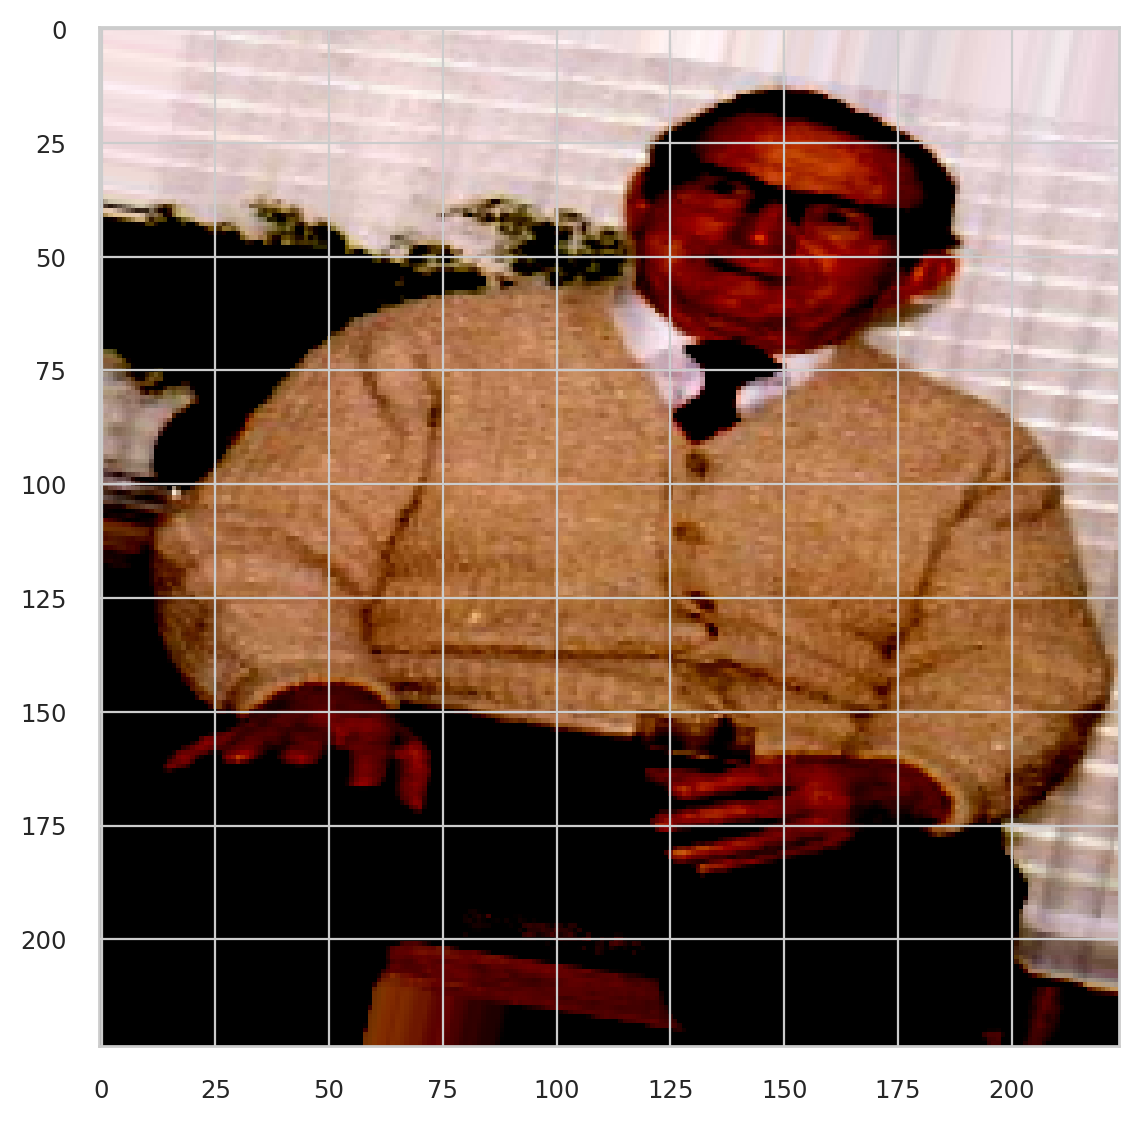

In [11]:
# # 증강 확인
plt.imshow(train_augmented_images[0][0][15])

In [12]:
from tensorflow.keras.layers import BatchNormalization, Dropout, Concatenate, Conv1D, Reshape, GlobalAveragePooling1D, MaxPool1D, BatchNormalization

In [27]:
def model_maker():
    drop_ratio = 0.2
    # top 층을 제외한 사전학습 모형 호출
    base_model = MobileNet(include_top=False,
                           input_shape=(224, 224, 3),
                           weights='imagenet')
    for layer in base_model.layers[:]:
        layer.trainable = True

    # Input 클래스를 이용해서 입력 데이터의 형태를 지정
    input_ = Input(shape=(224, 224, 3))
    custom_model = base_model(input_)

    custom_model = GlobalAveragePooling2D()(custom_model)
    d_1_1 = Dense(1024, activation='relu')(custom_model)
    d_1_1 = BatchNormalization()(d_1_1)
    d_1_2 = Dropout(drop_ratio)(d_1_1)
    d_1_3 = Dense(512, activation='relu')(d_1_2)

    d_2_1 = BatchNormalization()(d_1_3)
    d_2_2 = Dropout(drop_ratio)(d_2_1)
    d_2_3 = Dense(256, activation='relu')(d_2_2)

    d_3_1 = BatchNormalization()(d_2_3)
    d_3_2 = Dropout(drop_ratio)(d_3_1)
    d_3_3 = Dense(64, activation='relu')(d_3_2)

    d_4_1 = BatchNormalization()(d_3_3)
    d_4_2 = Dropout(drop_ratio)(d_4_1)
    d_4_3 = Dense(32, activation='relu')(d_4_2)

    d_5_1 = BatchNormalization()(d_4_3)
    d_5_2 = Dropout(drop_ratio)(d_5_1)
    d_5_3 = Dense(16, activation='relu')(d_5_2)

    d_out = Dropout(drop_ratio)(d_5_3)


    reshaped_dout_2_4_for_conv1D = Reshape((1,16))(d_out)

    concat_1 = Concatenate(axis=1)([d_1_3,d_2_3,d_3_3,d_4_3,d_5_3])
    dout_3 = Dropout(drop_ratio)(concat_1)
    custom_model = Dense(16, activation='relu')(dout_3)
    custom_model = BatchNormalization()(custom_model)
    dout_4 = Dropout(drop_ratio)(custom_model)
    reshaped_for_conv1D = Reshape((1,16))(dout_4)

    conv_1 = Conv1D(256, 3, padding='same', activation='relu')(reshaped_for_conv1D)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Conv1D(16, 1, padding='same', activation='relu')(conv_1)
    conv_2 = Conv1D(256, 12, padding='same', activation='relu')(reshaped_for_conv1D)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Conv1D(16, 1, padding='same', activation='relu')(conv_2)
    conv_3 = Conv1D(256, 18, padding='same', activation='relu')(reshaped_for_conv1D)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Conv1D(16, 1, padding='same', activation='relu')(conv_3)
    conv_4 = Conv1D(256, 30, padding='same', activation='relu')(reshaped_for_conv1D)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Conv1D(16, 1, padding='same', activation='relu')(conv_4)
    conv_5 = Conv1D(256, 120, padding='same', activation='relu')(reshaped_for_conv1D)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Conv1D(16, 1, padding='same', activation='relu')(conv_5)
    conv_6 = Conv1D(256, 180, padding='same', activation='relu')(reshaped_for_conv1D)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Conv1D(16, 1, padding='same', activation='relu')(conv_6)

    concat_2 = Concatenate(axis=1)([conv_1,conv_2,conv_3, conv_4,conv_5,conv_6,
                                    reshaped_dout_2_4_for_conv1D,reshaped_for_conv1D])
    custom_model = GlobalAveragePooling1D()(concat_2)

    dout_5 = Dropout(drop_ratio)(custom_model)
    custom_model = Dense(64, activation='relu')(dout_5)
    custom_model = BatchNormalization()(custom_model)

    # custom_model = Dense(32, activation='relu')(custom_model)
    # custom_model = BatchNormalization()(custom_model)

    # custom_model = Dense(16, activation='relu')(custom_model)
    # custom_model = BatchNormalization()(custom_model)

    dout_6 = Dropout(drop_ratio)(custom_model)
    predictions  = Dense(2, activation='softmax')(dout_6)
    return Model(inputs=input_, outputs=predictions)

In [28]:

import inspect
import sys
import io
import os

name_ = '파인 튜닝'
codes_ = inspect.getsource(model_maker)

model = model_maker()
model.summary()

summary_str = io.StringIO()
model.summary(print_fn=lambda x: summary_str.write(x + '\n'))

folder = 'result/'
files = os.listdir(folder)

last_number = int(len(files) / 3)
with open(folder + f'{name_}_{last_number}.txt', 'w') as f:
    f.write(codes_ + '\n\n')
    f.write(summary_str.getvalue() + '\n\n')

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenet_1.00_224  │ (None, 7, 7,      │  3,228,864 │ input_layer_3[0]… │
│ (Functional)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1024)      │          0 │ mobilenet_1.00_2… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1024)      │  1,049,600 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 1024)      │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 512)       │    524,800 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_10[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 256)       │    131,328 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_11[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │     16,448 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_12[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 32)        │      2,080 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_13[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 32)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 6,496,034 (24.78 MB)

 Trainable params: 6,467,138 (24.67 MB)

 Non-trainable params: 28,896 (112.88 KB)

### 트레인 데이터 확인

[1. 0.]


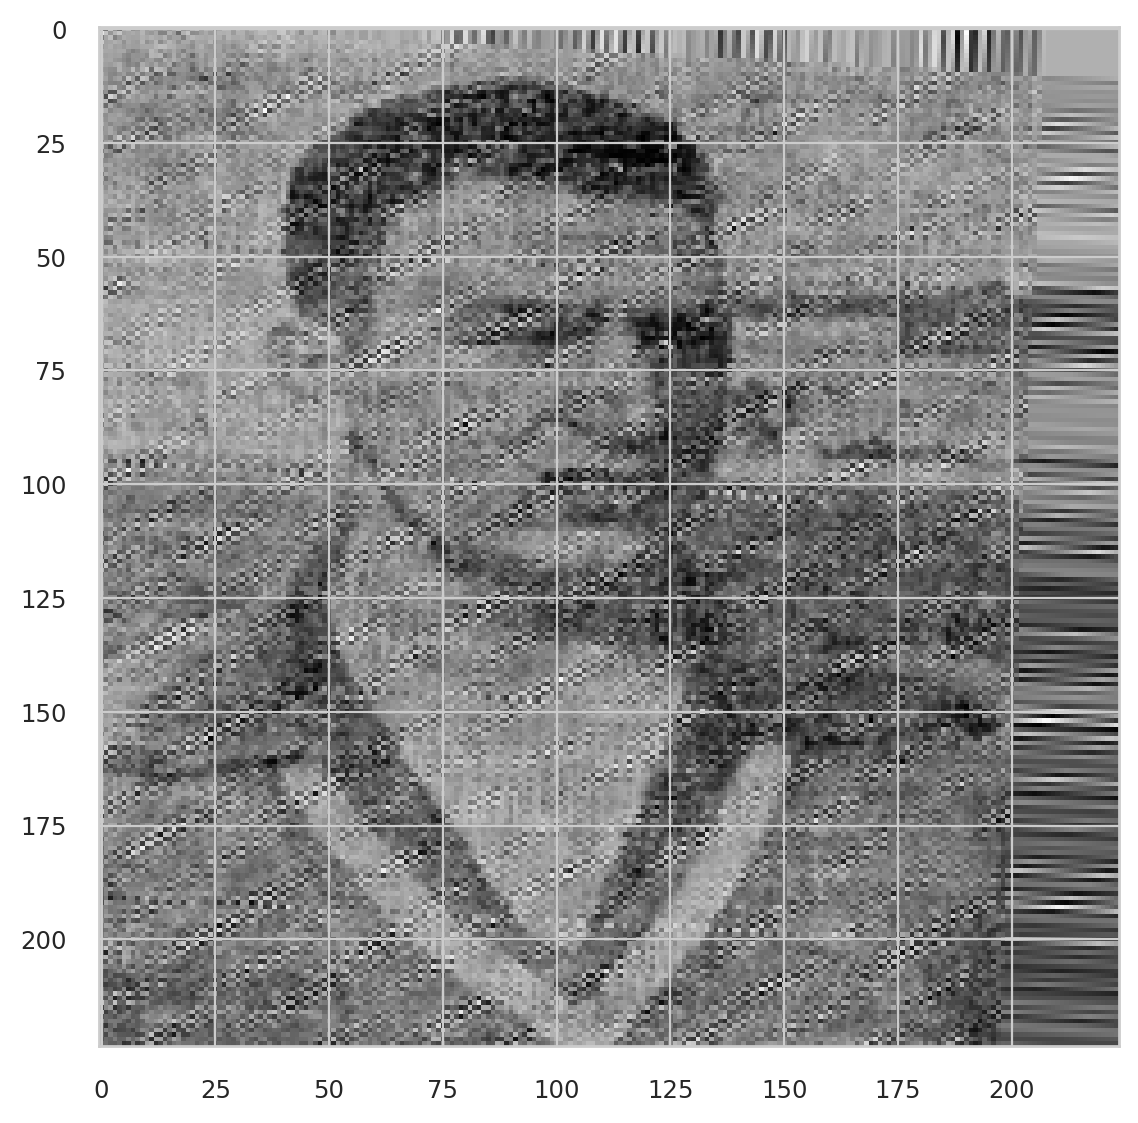

In [29]:
for i in train_augmented_images:
    plt.imshow((i[0][0] + 1)/2)
    print(i[1][0])
    break

### 테스트 데이터 확인

[0. 1.]


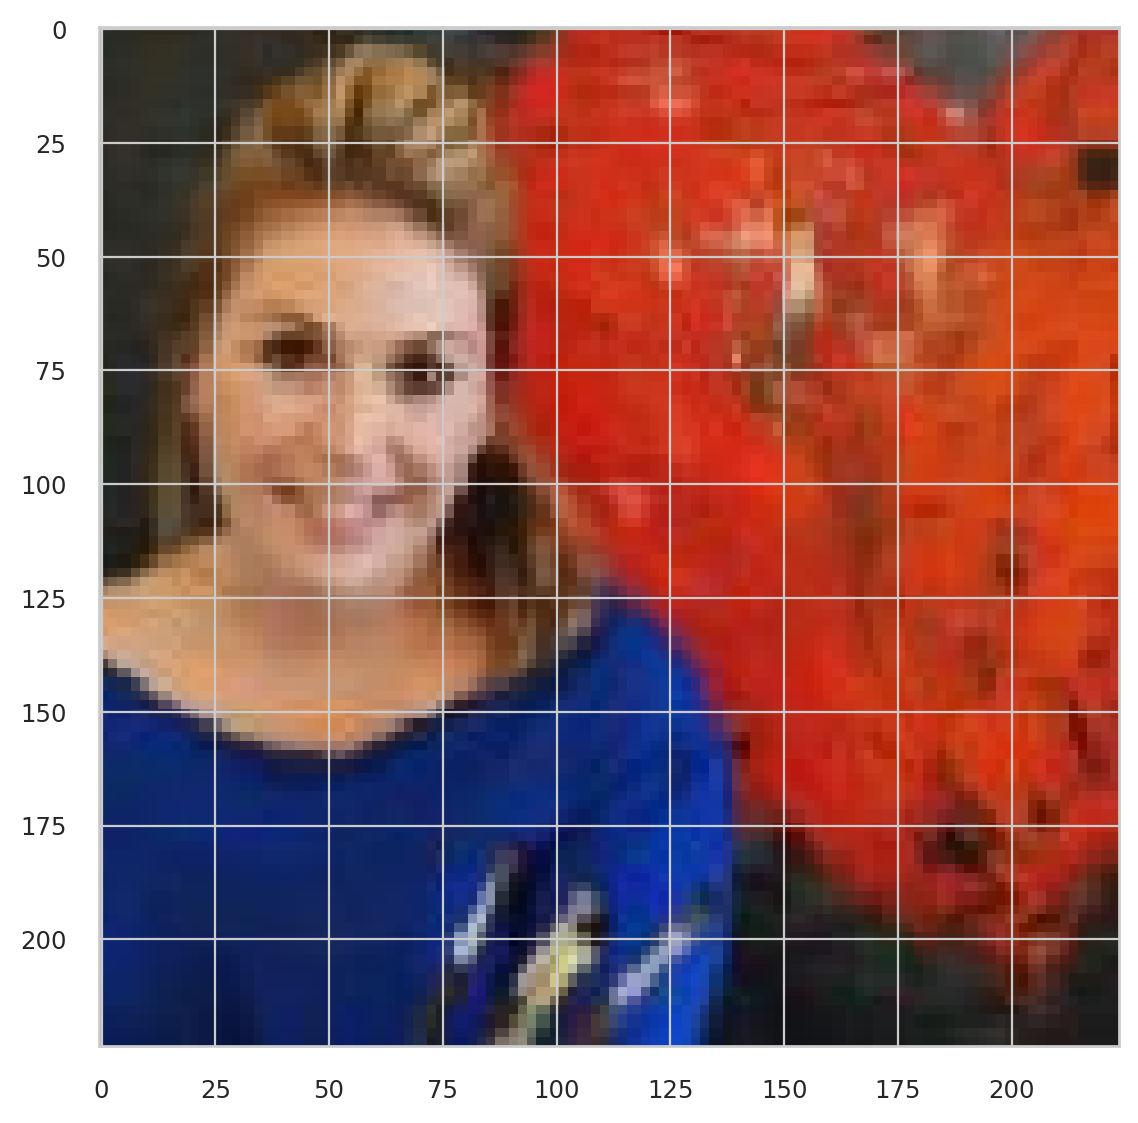

In [30]:
for i in test_augmented_images:
    plt.imshow((i[0][0] + 1)/2)
    print(i[1][0])
    break

In [31]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])


In [32]:
with open(folder + f'{name_}_{last_number}.txt', 'a') as f:
    f.write(model.loss + '\n')
    f.write(f'Model_optimizer : {model.optimizer.__str__()}' + '\n')
    f.write(f'Model_Learning_rate : {model.optimizer.learning_rate.numpy():.5f}' + '\n\n')

In [33]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(patience=20)
checkpoint = ModelCheckpoint('3_2_fine_tuning_final_model.keras',
                             monitor='val_loss', 
                             save_best_only=True, 
                             mode='min', 
                             verbose=1)

In [34]:
history = model.fit(
                    train_augmented_images,
                    # x_train,y_train,
                    batch_size = 32,
                    epochs = 1200,
                    callbacks=[checkpoint, es],
                    validation_data = test_augmented_images)

Epoch 1/1200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5197 - loss: 0.9761  
Epoch 1: val_loss improved from inf to 0.69576, saving model to 3_2_fine_tuning_final_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 51s 5s/step - accuracy: 0.5217 - loss: 0.9740 - val_accuracy: 0.3971 - val_loss: 0.6958
Epoch 2/1200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.5386 - loss: 0.9244
Epoch 2: val_loss improved from 0.69576 to 0.69202, saving model to 3_2_fine_tuning_final_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - accuracy: 0.5386 - loss: 0.9333 - val_accuracy: 0.4706 - val_loss: 0.6920
Epoch 3/1200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.4913 - loss: 0.9606
Epoch 3: val_loss improved from 0.69202 to 0.68883, saving model to 3_2_fine_tuning_final_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.4930 - loss: 0.9615 - val_accuracy: 0.6471 - val_loss: 0.6888
Epoch 4/1200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.5521 - loss: 0.8905
Epoch 4: val

In [35]:
with open(folder + f'{name_}_{last_number}.txt', 'a') as f:
    f.write('epoch, loss, acc, val_loss, val_accu' + '\n')

for each in range(len(history.history['loss'])):
    loss= format(history.history['loss'][each], '.4f')
    acc = format(history.history['accuracy'][each], '.4f')
    val_loss = format(history.history['val_loss'][each], '.4f')
    val_accu = format(history.history['val_accuracy'][each], '.4f')
    print(loss,acc,val_loss,val_accu)
    with open(folder + f'{name_}_{last_number}.txt', 'a') as f:
        f.write(f'{loss},{acc},{val_loss},{val_accu}' + '\n')

0.9638 0.5316 0.6958 0.3971
0.9778 0.5390 0.6920 0.4706
0.9659 0.5019 0.6888 0.6471
0.8352 0.5874 0.6859 0.6765
0.8291 0.6134 0.6831 0.6176
0.7972 0.5799 0.6809 0.5882
0.8305 0.5762 0.6792 0.5735
0.7842 0.6022 0.6776 0.5882
0.8495 0.5836 0.6756 0.5882
0.7688 0.6320 0.6730 0.5882
0.7173 0.6320 0.6700 0.5735
0.6205 0.6952 0.6677 0.5735
0.6203 0.6952 0.6656 0.5735
0.6092 0.7026 0.6638 0.5735
0.6123 0.7063 0.6622 0.5735
0.6734 0.6729 0.6607 0.5735
0.6327 0.6803 0.6588 0.5735
0.6693 0.6654 0.6568 0.5735
0.5908 0.6803 0.6540 0.5735
0.5832 0.7138 0.6514 0.5882
0.5679 0.7026 0.6492 0.5882
0.5377 0.7286 0.6462 0.6029
0.4934 0.7398 0.6437 0.6029
0.4482 0.7918 0.6414 0.6029
0.4825 0.7509 0.6381 0.6029
0.4670 0.7472 0.6342 0.6029
0.4743 0.7770 0.6327 0.6029
0.3927 0.8104 0.6311 0.6029
0.4070 0.8178 0.6275 0.6029
0.3215 0.8550 0.6254 0.6176
0.3982 0.8178 0.6210 0.6176
0.3489 0.8401 0.6142 0.6176
0.3625 0.8364 0.6090 0.6176
0.3219 0.8587 0.6050 0.6176
0.3206 0.8662 0.6007 0.6176
0.2970 0.8885 0.5943

In [36]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model

plot_model(model, to_file= folder + f'{name_}_{last_number}.png', show_shapes=True, show_layer_names=False,
    rankdir="TB", expand_nested=False, dpi=266,
    show_layer_activations=False,)

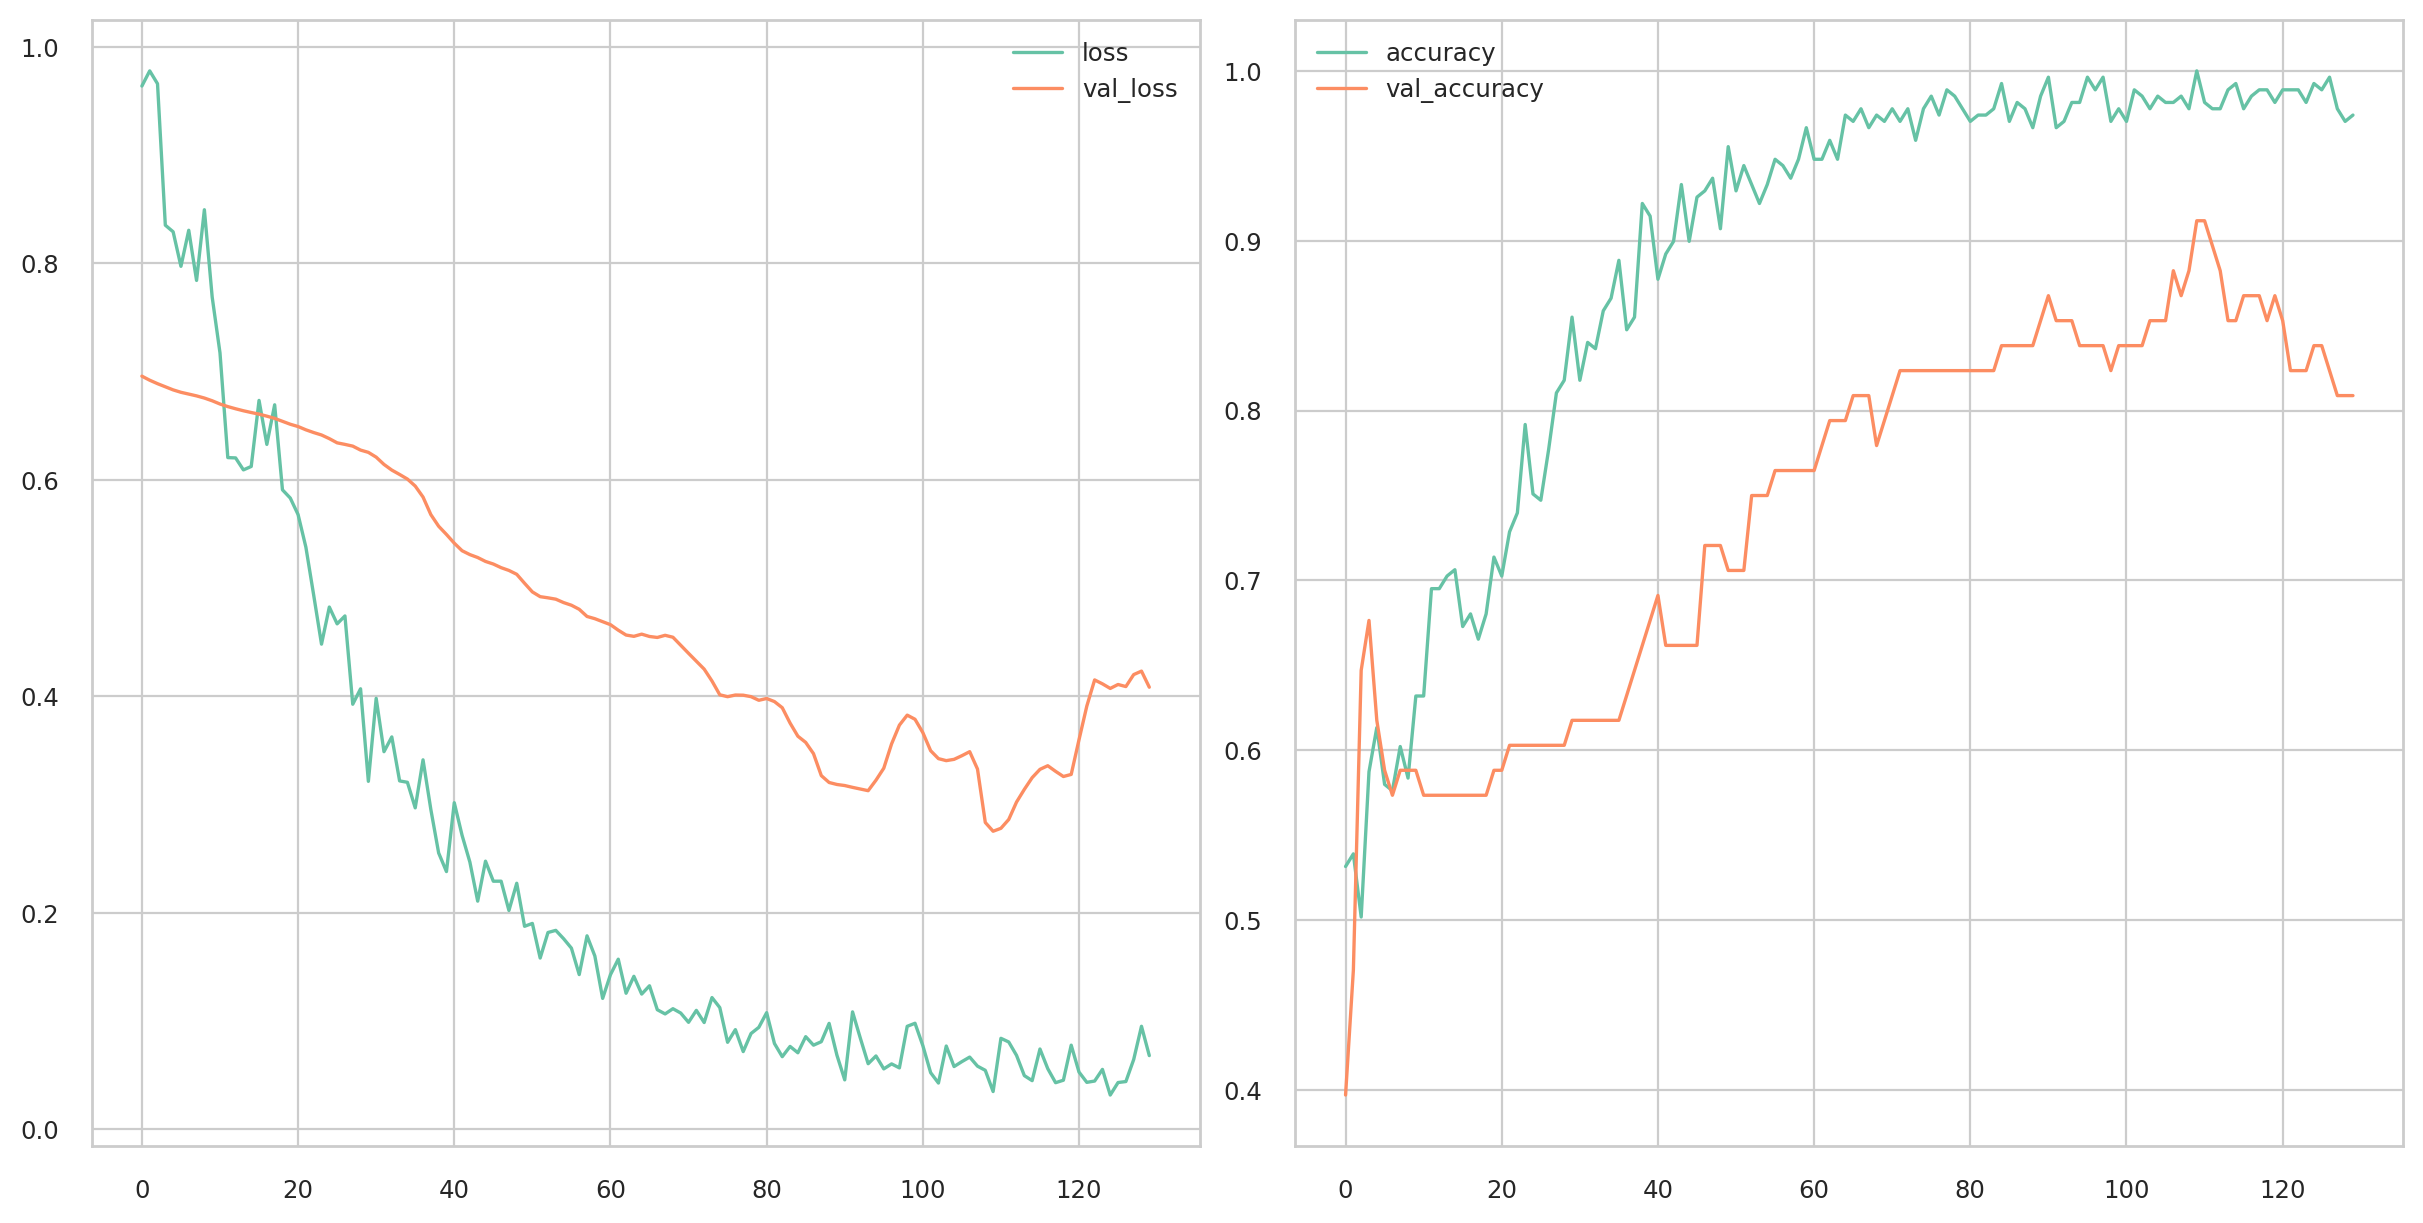

In [37]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.lineplot(history.history['loss'],
             label='loss',
             ax=ax[0])

sns.lineplot(history.history['val_loss'],
             label='val_loss',
             ax=ax[0])

sns.lineplot(history.history['accuracy'],
             label='accuracy',
             ax=ax[1])

sns.lineplot(history.history['val_accuracy'],
             label='val_accuracy',
             ax=ax[1])

fig.savefig(folder + f"{name_}_{last_number}_graph.png")

In [38]:
model.load_weights('3_2_fine_tuning_final_model.keras')

In [39]:
from sklearn.metrics import f1_score

In [40]:
pred = [i.argmax() for i in model.predict(x_test,verbose=0)]
y_real = [i.argmax() for i in y_test]

f1 = f1_score(pred,y_real)
final_result_ = f'정확도 : {model.evaluate(test_augmented_images, verbose=0)[1]}, f1_socre: {f1}'

with open(folder + f'{name_}_{last_number}.txt', 'a') as f:
    f.write('최종 스코어' + '\n')
    f.write('\n\n' + final_result_ + '\n')

```py


```

